# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.shape

(7591, 2)

In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


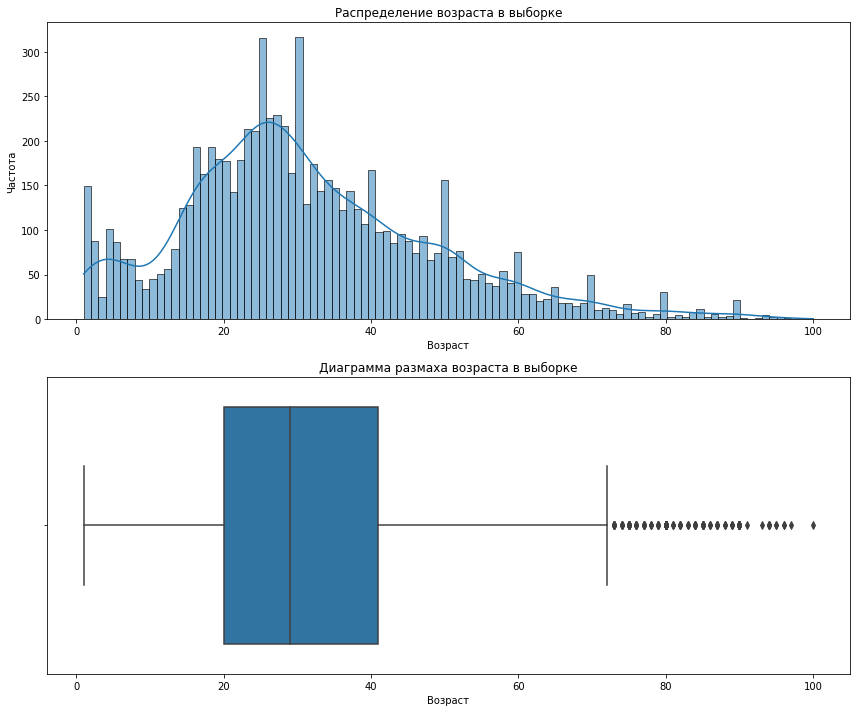

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

sns.histplot(data['real_age'], bins=100, kde=True, ax=ax[0])
ax[0].set_title('Распределение возраста в выборке')
ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Частота')

sns.boxplot(x=data['real_age'], ax=ax[1])
ax[1].set_title('Диаграмма размаха возраста в выборке')
ax[1].set_xlabel('Возраст')


plt.tight_layout()
plt.show()

In [8]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [9]:
images, ages = next(gen_flow)

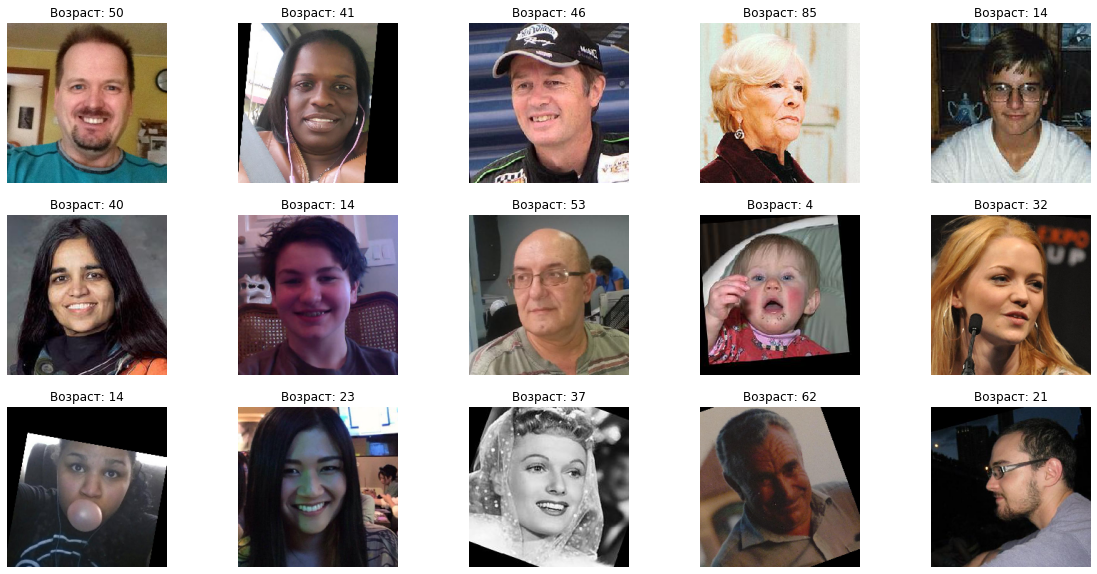

In [10]:
num_images = 15
plt.figure(figsize=(20, 10))

for i in range(num_images):
    ax = plt.subplot(3, 5, i + 1) 
    plt.imshow(images[i])
    plt.title(f"Возраст: {ages[i]}")
    plt.axis('off')  
plt.show()

Данные представлены в виде 7591 фотографий. labels.csv представлен ввиде датафрейма, состоящего из двух столбцов file_name и real_age. Больше всего фотографий в возрасте от 20 до 41. Минимальное значение 1, максимальное 100. На некоторых фотографиях люди в головных уборах, очках, некоторые лица запечатлены в профиль. Это может усложнить определение возраста моделью

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1 / 255.0,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2
    )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1 / 255.0
    )

    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    for layer in backbone.layers:
        layer.trainable = False

    return model


def train_model(model, train_data,

                test_data, batch_size=None, epochs=15,
                
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```



```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```
### Результаты обучения модели

Train for 178 steps, validate for 60 steps

Epoch 1/15

178/178 - 131s - loss: 221.7604 - mae: 10.9188 - val_loss: 492.6157 - val_mae: 17.1085

Epoch 2/15

178/178 - 101s - loss: 105.0896 - mae: 7.7742 - val_loss: 380.7905 - val_mae: 14.5506

Epoch 3/15

178/178 - 100s - loss: 85.1286 - mae: 6.9701 - val_loss: 350.2094 - val_mae: 13.8212

Epoch 4/15

178/178 - 100s - loss: 72.1913 - mae: 6.4716 - val_loss: 142.4435 - val_mae: 9.1069

Epoch 5/15

178/178 - 100s - loss: 63.8011 - mae: 6.1213 - val_loss: 114.0568 - val_mae: 8.1351

Epoch 6/15


178/178 - 100s - loss: 54.0339 - mae: 5.7029 - val_loss: 79.8786 - val_mae: 6.6830

Epoch 7/15

178/178 - 100s - loss: 49.0421 - mae: 5.3630 - val_loss: 87.1945 - val_mae: 6.8347

Epoch 8/15

178/178 - 100s - loss: 43.6781 - mae: 5.0457 - val_loss: 76.0161 - val_mae: 6.5534

Epoch 9/15

178/178 - 100s - loss: 40.1364 - mae: 4.8816 - val_loss: 99.7911 - val_mae: 7.4636

Epoch 10/15

178/178 - 100s - loss: 38.3215 - mae: 4.7531 - val_loss: 72.5322 - val_mae: 6.4859

Epoch 11/15

178/178 - 100s - loss: 34.0320 - mae: 4.4771 - val_loss: 71.2465 - val_mae: 6.1194

Epoch 12/15

178/178 - 100s - loss: 33.7204 - mae: 4.4280 - val_loss: 82.3428 - val_mae: 6.8292

Epoch 13/15

178/178 - 100s - loss: 31.8618 - mae: 4.2860 - val_loss: 74.0604 - val_mae: 6.3844

Epoch 14/15

178/178 - 100s - loss: 28.0740 - mae: 4.0932 - val_loss: 86.8729 - val_mae: 6.8229

Epoch 15/15

178/178 - 99s - loss: 30.1101 - mae: 4.2133 - val_loss: 70.1201 - val_mae: 6.2344

60/60 - 10s - loss: 70.1201 - mae: 6.2344

## Анализ обученной модели

Выводы из результатов обучения модели:

- **Архитектура**: Для обучения использовалась сверточная нейросеть **ResNet50**, которая была предварительно обучена на наборе данных **ImageNet**. Это означает, что модель использовала предобученные веса, что позволило улучшить результаты.

- **Размер батча**: Использовали **размер батча** равный **32**.

- **Оптимизатор**: В качестве оптимизатора использовался **Adam** с обучающей скоростью **0.0001**.

- **Заморозка весов**: В процессе обучения осуществлялась **заморозка весов** бэкбона, что позволило сохранить предобученные параметры и сосредоточиться на обучении новых слоев модели.

- **Количество эпох**: Модель обучалась в течение **15 эпох**.

- **Снижение потерь**: Наблюдается **снижение потерь** как на обучающей, так и на валидационной выборке. Это говорит о том, что модель успешно обучается и корректирует свои параметры для повышения точности.

- **Средняя абсолютная ошибка (MAE)**: Значение MAE на обучающей выборке снижается, что указывает на то, что предсказания модели становятся все более точными с каждой эпохой. Например, в первой эпохе MAE составляет **10.9188**, а к последней эпохе уменьшается до **4.2133**.

- **Наилучшее значение MAE**: Наилучшее значение MAE **6.1194** было получено на **11 эпохе**.

- **Отсутствие переобучения**: В процессе обучения не были замечены явные признаки **переобучения**, так как валидационные метрики снижались на протяжении всех эпох.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы